<a href="https://colab.research.google.com/github/tomek-l/video-mining/blob/master/Video_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torchvision import models
from torchvision import transforms

In [2]:
import numpy as np
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Move channel axes - go from (N,H,W,C) convention to (N,C,H,W)
X_train = np.moveaxis(X_train, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

# Convert Feature Vectors to FP32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [3]:
X_train[0].shape

(3, 32, 32)

In [0]:
from torch.utils.data.dataset import Dataset
 
class CIFAR10_custom_ds(Dataset):
    def __init__(self, feature_vec, labels, device):
        self._device = device
        self.x = feature_vec
        self.y = labels 

        # I only do eager conversion to CUDA memory since CIFAR10 is relatively small
        # (will only take some ~200MB of memory)
        self.x = torch.tensor(self.x).to(self._device)
        self.y = torch.tensor(self.y).to(self._device)
         
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
 
    def __len__(self):
        return len(self.x)

In [0]:
# pytorch way to use CIFAR-10
# (with DataLoader class)

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
import torch.nn as nn

# Let's define a simple NN based of resnet18
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = torch.nn.Linear(512, n_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.backbone(x)
        x = self.sigmoid(x)
        return x


In [0]:
from torch.utils.data import DataLoader

# import torch.multiprocessing as mp
# try:
#     mp.set_start_method("spawn")
# except RuntimeError as e:
#     print(e)
#     pass

GPU = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainset = CIFAR10_custom_ds(X_train, y_train, GPU)
assert trainset[0:4] 
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

In [12]:
from torch import optim 

net = Net(10).to(GPU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print_every = 100
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:    # print every 100 mini-batches
            print(f'epoch {epoch+1} batch {i+1} loss: {(running_loss / print_every):.4f}')
            running_loss = 0.0

print('Finished Training')

epoch 1 batch 100 loss: 2.2282
epoch 1 batch 200 loss: 2.1144
epoch 1 batch 300 loss: 2.0518
epoch 1 batch 400 loss: 2.0111
epoch 1 batch 500 loss: 1.9868
epoch 1 batch 600 loss: 1.9710
epoch 1 batch 700 loss: 1.9514
epoch 2 batch 100 loss: 1.9158
epoch 2 batch 200 loss: 1.9051
epoch 2 batch 300 loss: 1.9037
epoch 2 batch 400 loss: 1.8992
epoch 2 batch 500 loss: 1.8843
epoch 2 batch 600 loss: 1.8871
epoch 2 batch 700 loss: 1.8846
epoch 3 batch 100 loss: 1.8629
epoch 3 batch 200 loss: 1.8601
epoch 3 batch 300 loss: 1.8578
epoch 3 batch 400 loss: 1.8502
epoch 3 batch 500 loss: 1.8462
epoch 3 batch 600 loss: 1.8485
epoch 3 batch 700 loss: 1.8417
epoch 4 batch 100 loss: 1.8251
epoch 4 batch 200 loss: 1.8209
epoch 4 batch 300 loss: 1.8215
epoch 4 batch 400 loss: 1.8232
epoch 4 batch 500 loss: 1.8125
epoch 4 batch 600 loss: 1.8209
epoch 4 batch 700 loss: 1.8151
epoch 5 batch 100 loss: 1.7934
epoch 5 batch 200 loss: 1.7891
epoch 5 batch 300 loss: 1.7919
epoch 5 batch 400 loss: 1.7904
epoch 5 

In [13]:
testset = CIFAR10_custom_ds(X_test, y_test, GPU)
testloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=0)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the  {len(y_test)} test images is {100 * correct / total} %')

Accuracy of the network on the  10000 test images is 62.6 %


In [0]:
trainset = CIFAR10_custom_ds(X_train[:10000], y_train[:10000], GPU)
assert trainset[0:4] 
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

In [29]:
from torch import optim 

net_small = Net(10).to(GPU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_small.parameters(), lr=0.001, momentum=0.9)
print_every = 100
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_small(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:    # print every 100 mini-batches
            print(f'epoch {epoch+1} batch {i+1} loss: {(running_loss / print_every):.4f}')
            running_loss = 0.0

print('Finished Training')

epoch 1 batch 100 loss: 2.2341
epoch 2 batch 100 loss: 2.0524
epoch 3 batch 100 loss: 1.9779
epoch 4 batch 100 loss: 1.9228
epoch 5 batch 100 loss: 1.8896
epoch 6 batch 100 loss: 1.8490
epoch 7 batch 100 loss: 1.8268
epoch 8 batch 100 loss: 1.7940
epoch 9 batch 100 loss: 1.7714
epoch 10 batch 100 loss: 1.7443
epoch 11 batch 100 loss: 1.7289
epoch 12 batch 100 loss: 1.7046
epoch 13 batch 100 loss: 1.6881
epoch 14 batch 100 loss: 1.6686
epoch 15 batch 100 loss: 1.6514
epoch 16 batch 100 loss: 1.6365
epoch 17 batch 100 loss: 1.6217
epoch 18 batch 100 loss: 1.6060
epoch 19 batch 100 loss: 1.5958
epoch 20 batch 100 loss: 1.5874
Finished Training


In [30]:
testset = CIFAR10_custom_ds(X_test, y_test, GPU)
testloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=0)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_small(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the  {len(y_test)} test images is {100 * correct / total} %')

Accuracy of the network on the  10000 test images is 46.66 %


In [0]:
trainset = CIFAR10_custom_ds(X_train[:20000], y_train[:20000], GPU)
assert trainset[0:4] 
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

In [33]:
from torch import optim 

net_random = Net(10).to(GPU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_random.parameters(), lr=0.001, momentum=0.9)
print_every = 100
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_random(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:    # print every 100 mini-batches
            print(f'epoch {epoch+1} batch {i+1} loss: {(running_loss / print_every):.4f}')
            running_loss = 0.0

print('Finished Training')

epoch 1 batch 100 loss: 2.2281
epoch 1 batch 200 loss: 2.1055
epoch 1 batch 300 loss: 2.0514
epoch 2 batch 100 loss: 1.9960
epoch 2 batch 200 loss: 1.9796
epoch 2 batch 300 loss: 1.9518
epoch 3 batch 100 loss: 1.9238
epoch 3 batch 200 loss: 1.9164
epoch 3 batch 300 loss: 1.9044
epoch 4 batch 100 loss: 1.8794
epoch 4 batch 200 loss: 1.8786
epoch 4 batch 300 loss: 1.8740
epoch 5 batch 100 loss: 1.8481
epoch 5 batch 200 loss: 1.8495
epoch 5 batch 300 loss: 1.8466
epoch 6 batch 100 loss: 1.8235
epoch 6 batch 200 loss: 1.8245
epoch 6 batch 300 loss: 1.8247
epoch 7 batch 100 loss: 1.7969
epoch 7 batch 200 loss: 1.8011
epoch 7 batch 300 loss: 1.7956
epoch 8 batch 100 loss: 1.7758
epoch 8 batch 200 loss: 1.7786
epoch 8 batch 300 loss: 1.7747
epoch 9 batch 100 loss: 1.7516
epoch 9 batch 200 loss: 1.7544
epoch 9 batch 300 loss: 1.7536
epoch 10 batch 100 loss: 1.7387
epoch 10 batch 200 loss: 1.7313
epoch 10 batch 300 loss: 1.7325
epoch 11 batch 100 loss: 1.7138
epoch 11 batch 200 loss: 1.7104
epo

In [36]:
testset = CIFAR10_custom_ds(X_test, y_test, GPU)
testloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=0)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_random(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the  {len(y_test)} test images is {100 * correct / total} %')

Accuracy of the network on the  10000 test images is 54.07 %


In [0]:
metrics.euc

In [40]:
.shape

(10000, 3072)

In [0]:
from sklearn import metrics

X_baseline = X_train[:10000]
X_to_sample = X_train[10000:]

dist = metrics.euclidean_distances(X_baseline.reshape(10000, -1).squeeze(), X_to_sample.reshape(40000, -1).squeeze())

In [0]:
sort_idx = np.argsort(dist.sum(axis=0))

In [0]:
our_pick = sort_idx[-10000:] # we pick thees to append X_baseline

In [0]:
X_new = np.concatenate([X_baseline, X_to_sample[our_pick]], axis=0)
y_new = np.concatenate([y_train[:10000], y_train[10000:][our_pick]], axis=0)

In [0]:
trainset = CIFAR10_custom_ds(X_new, y_new, GPU)
assert trainset[0:4] 
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

In [73]:
from torch import optim 

net_l2 = Net(10).to(GPU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_l2.parameters(), lr=0.001, momentum=0.9)
print_every = 100
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_l2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:    # print every 100 mini-batches
            print(f'epoch {epoch+1} batch {i+1} loss: {(running_loss / print_every):.4f}')
            running_loss = 0.0

print('Finished Training')

epoch 1 batch 100 loss: 2.2312
epoch 1 batch 200 loss: 2.1214
epoch 1 batch 300 loss: 2.0528
epoch 2 batch 100 loss: 1.9960
epoch 2 batch 200 loss: 1.9740
epoch 2 batch 300 loss: 1.9526
epoch 3 batch 100 loss: 1.9170
epoch 3 batch 200 loss: 1.9108
epoch 3 batch 300 loss: 1.9022
epoch 4 batch 100 loss: 1.8726
epoch 4 batch 200 loss: 1.8694
epoch 4 batch 300 loss: 1.8695
epoch 5 batch 100 loss: 1.8403
epoch 5 batch 200 loss: 1.8441
epoch 5 batch 300 loss: 1.8406
epoch 6 batch 100 loss: 1.8111
epoch 6 batch 200 loss: 1.8159
epoch 6 batch 300 loss: 1.8122
epoch 7 batch 100 loss: 1.7864
epoch 7 batch 200 loss: 1.7912
epoch 7 batch 300 loss: 1.7900
epoch 8 batch 100 loss: 1.7666
epoch 8 batch 200 loss: 1.7704
epoch 8 batch 300 loss: 1.7729
epoch 9 batch 100 loss: 1.7469
epoch 9 batch 200 loss: 1.7457
epoch 9 batch 300 loss: 1.7475
epoch 10 batch 100 loss: 1.7245
epoch 10 batch 200 loss: 1.7277
epoch 10 batch 300 loss: 1.7301
epoch 11 batch 100 loss: 1.7068
epoch 11 batch 200 loss: 1.7079
epo

In [74]:
testset = CIFAR10_custom_ds(X_test, y_test, GPU)
testloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=0)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_l2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the  {len(y_test)} test images is {100 * correct / total} %')

Accuracy of the network on the  10000 test images is 52.32 %


In [102]:
np.argsort(dist[:,0])

array([ 521, 6965, 3949, ..., 5867, 6400, 9522])

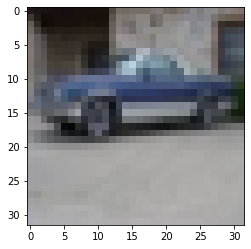

In [100]:
plt.imshow(np.rollaxis(X_to_sample[0], 0, 3).astype(np.uint8))

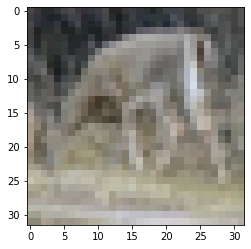

In [103]:
plt.imshow(np.rollaxis(X_baseline[521], 0, 3).astype(np.uint8))

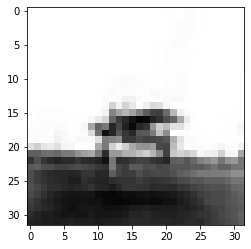

In [106]:
plt.imshow(np.rollaxis(X_baseline[9522], 0, 3).astype(np.uint8))